In [43]:
# 0.预先准备
%pip install pandas numpy matplotlib arch statsmodels
%pip install yfinance pandas_datareader requests
%pip install seaborn
%pip install networkx
%pip install scikit-learn

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [44]:
# ==========================================
# Section 1: Environment Setup & Data Cleaning
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm
import yfinance as yf
import pandas_datareader.data as web
import requests
import datetime
import warnings
import time
import random

print("量化建模环境已就绪！")
# 1. 基础配置
# ------------------------------------------------------------------------------
warnings.filterwarnings('ignore')

print("-" * 60)
print("📋 阶段一：数据抓取 (含防封锁延迟策略)")
print("-" * 60)

# 1.1 时间与资产定义
start_date_download = "2009-12-01" 
start_date_analysis = "2010-01-01"
end_date = "2024-12-31"

ticker_map = {
    "CLF": "CL=F",
    "GCF": "GC=F",
    "SIF": "SI=F",
    "HGF": "HG=F",
    "GSPC": "^GSPC",
    "DJI": "^DJI",
    "IXIC": "^IXIC"
}


量化建模环境已就绪！
------------------------------------------------------------
📋 阶段一：数据抓取 (含防封锁延迟策略)
------------------------------------------------------------


In [45]:
# 1.2. 资产数据下载 (核心修改部分)
# ------------------------------------------------------------------------------
print(f"\n🔍 开始下载 {len(ticker_map)} 个核心资产 (每项随机等待 3-6 秒)...")

asset_data_dict = {}
download_fail = []

for var_name, ticker in ticker_map.items():
    max_retries = 5 # 增加重试次数
    success = False
    
    # === 关键修改：添加随机延迟，防止被认为是机器人 ===
    sleep_time = random.uniform(3, 6)
    print(f"\n⏳ 休息 {sleep_time:.1f} 秒...")
    time.sleep(sleep_time)
    
    for attempt in range(1, max_retries + 1):
        try:
            print(f"👉 [{var_name}] 正在下载: {ticker} (第 {attempt} 次尝试)...")
            
            # === 关键修改：添加 multi_level_index=False 防止列名错乱 ===
            df_daily = yf.download(ticker, start=start_date_download, end=end_date, progress=False, multi_level_index=False)
            
            # === 关键修改：先检查数据是否为空 ===
            if df_daily.empty:
                print(f"   ⚠️  警告: 返回数据为空，可能网络超时")
                raise ValueError("Empty Data")
            
            # 2.1 获取收盘价 (兼容性处理)
            if 'Adj Close' in df_daily.columns:
                price_series = df_daily['Adj Close']
            elif 'Close' in df_daily.columns:
                print("   ℹ️  提示: 未找到 Adj Close，使用 Close 代替")
                price_series = df_daily['Close']
            else:
                raise ValueError(f"列名异常: {df_daily.columns}")
            
            # 2.2 重采样与计算收益率
            monthly_price = price_series.resample('ME').last()
            monthly_log_ret = np.log(monthly_price / monthly_price.shift(1))
            monthly_log_ret = monthly_log_ret[start_date_analysis:]
            
            # 数据量检查
            if len(monthly_log_ret) < 170:
                 raise ValueError(f"数据量不足 ({len(monthly_log_ret)}行)")

            asset_data_dict[var_name] = monthly_log_ret
            success = True
            print(f"✅ {var_name} 下载成功! (行数: {len(monthly_log_ret)})")
            break # 成功则跳出重试循环
            
        except Exception as e:
            print(f"❌ 第 {attempt} 次失败: {e}")
            # 失败后等待更长时间再重试
            time.sleep(random.uniform(5, 10))
    
    if not success:
        download_fail.append(var_name)
        print(f"❌ {var_name}: 最终下载失败")



🔍 开始下载 7 个核心资产 (每项随机等待 3-6 秒)...

⏳ 休息 5.9 秒...
👉 [CLF] 正在下载: CL=F (第 1 次尝试)...
   ℹ️  提示: 未找到 Adj Close，使用 Close 代替
✅ CLF 下载成功! (行数: 180)

⏳ 休息 5.3 秒...
👉 [GCF] 正在下载: GC=F (第 1 次尝试)...
   ℹ️  提示: 未找到 Adj Close，使用 Close 代替
✅ GCF 下载成功! (行数: 180)

⏳ 休息 3.6 秒...
👉 [SIF] 正在下载: SI=F (第 1 次尝试)...
   ℹ️  提示: 未找到 Adj Close，使用 Close 代替
✅ SIF 下载成功! (行数: 180)

⏳ 休息 4.6 秒...
👉 [HGF] 正在下载: HG=F (第 1 次尝试)...
   ℹ️  提示: 未找到 Adj Close，使用 Close 代替
✅ HGF 下载成功! (行数: 180)

⏳ 休息 4.1 秒...
👉 [GSPC] 正在下载: ^GSPC (第 1 次尝试)...
   ℹ️  提示: 未找到 Adj Close，使用 Close 代替
✅ GSPC 下载成功! (行数: 180)

⏳ 休息 5.4 秒...
👉 [DJI] 正在下载: ^DJI (第 1 次尝试)...
   ℹ️  提示: 未找到 Adj Close，使用 Close 代替
✅ DJI 下载成功! (行数: 180)

⏳ 休息 5.0 秒...
👉 [IXIC] 正在下载: ^IXIC (第 1 次尝试)...
   ℹ️  提示: 未找到 Adj Close，使用 Close 代替
✅ IXIC 下载成功! (行数: 180)


In [46]:
# 1.3. 合并资产数据
# ------------------------------------------------------------------------------
if asset_data_dict:
    df_assets = pd.DataFrame(asset_data_dict)
    df_assets.index.name = 'Date'
else:
    raise RuntimeError("所有资产下载失败，请检查 VPN 连接是否稳定")

In [47]:
# 1.4. FEDFUNDS 利率数据下载
# ------------------------------------------------------------------------------
print("\n🔍 开始下载 FEDFUNDS 数据 (来源: FRED)...")
# 同样添加延迟
time.sleep(3) 

try:
    df_fed = web.DataReader('FEDFUNDS', 'fred', start_date_download, end_date)
    df_fed_monthly = df_fed.resample('ME').last()
    df_fed_monthly.columns = ['FEDFUNDS.level']
    df_fed_aligned = df_fed_monthly[start_date_analysis:].ffill()
    print(f"✅ FEDFUNDS 下载成功! ({len(df_fed_aligned)}行)")
except Exception as e:
    print(f"❌ FEDFUNDS 下载失败: {e}")
    df_fed_aligned = pd.DataFrame()


🔍 开始下载 FEDFUNDS 数据 (来源: FRED)...
✅ FEDFUNDS 下载成功! (180行)


In [51]:
# 1.5. 最终合并与保存
# ------------------------------------------------------------------------------
df_merged = pd.merge(df_assets, df_fed_aligned, left_index=True, right_index=True, how='inner')
df_final = df_merged.dropna()

print("\n" + "-" * 60)
print(f"📊 最终结果: {len(df_final)} 行 x {len(df_final.columns)} 列")
if len(download_fail) > 0:
    print(f"⚠️  失败资产: {download_fail}")
else:
    print("✅ 所有资产下载完整！")
    
df_final.to_csv("phase1_data.csv")
print("💾 数据已保存至 phase1_data.csv")
print("-" * 60)
print(df_final.head())


------------------------------------------------------------
📊 最终结果: 180 行 x 8 列
✅ 所有资产下载完整！
💾 数据已保存至 phase1_data.csv
------------------------------------------------------------
                 CLF       GCF       SIF       HGF      GSPC       DJI  \
Date                                                                     
2010-01-31 -0.085043 -0.011202 -0.038726 -0.088392 -0.037675 -0.035204   
2010-02-28  0.088816  0.032075  0.019399  0.070502  0.028115  0.025298   
2010-03-31  0.050188 -0.004481  0.059526  0.081489  0.057133  0.050183   
2010-04-30  0.028134  0.058271  0.060866 -0.060598  0.014651  0.013902   
2010-05-31 -0.152430  0.026838 -0.010805 -0.074788 -0.085532 -0.082522   

                IXIC  FEDFUNDS.level  
Date                                  
2010-01-31 -0.055171            0.11  
2010-02-28  0.041464            0.13  
2010-03-31  0.068920            0.16  
2010-04-30  0.026027            0.20  
2010-05-31 -0.086591            0.20  


In [53]:
# ==========================================
# Section 2: Stylized Facts (Dual-Axis Plots)
# ==========================================
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import time

print("-" * 60)
print("📋 阶段二：双轴价格趋势对比图")
print("-" * 60)

# 2.1. 定义要对比的组合
pairs = [
    ("CL=F", "^GSPC", "Crude Oil (CLF)", "S&P 500 (GSPC)"),
    ("GC=F", "^GSPC", "Gold (GCF)", "S&P 500 (GSPC)"),
    ("CL=F", "HG=F",  "Crude Oil (CLF)", "Copper (HGF)"),
    ("GC=F", "CL=F",  "Gold (GCF)", "Crude Oil (CLF)")
]

------------------------------------------------------------
📋 阶段二：双轴价格趋势对比图
------------------------------------------------------------


In [54]:
# 2.2. 下载数据 (增加防报错机制)
tickers = ["CL=F", "GC=F", "HG=F", "^GSPC"]
print("⏳ 正在休眠 5 秒以防封锁...")
time.sleep(5) 

print(f"⏳ 正在获取最新价格数据: {tickers} ...")

try:
    # 尝试下载，不强制指定列结构
    raw_data = yf.download(tickers, start="2010-01-01", end="2024-12-31", progress=False)
    
    # 检查数据是否为空
    if raw_data.empty:
        raise ValueError("下载的数据为空，可能是网络问题或被限制访问。")

    # 智能提取价格列
    # yfinance 有时返回 'Adj Close'，有时只有 'Close'
    if 'Adj Close' in raw_data.columns.get_level_values(0):
        df_prices = raw_data['Adj Close']
        print("✅ 成功获取 'Adj Close' 数据")
    elif 'Close' in raw_data.columns.get_level_values(0):
        df_prices = raw_data['Close']
        print("✅ 未找到 'Adj Close'，已自动切换为 'Close' (对期货/指数无影响)")
    else:
        # 极少数情况，尝试直接读取
        df_prices = raw_data
        print("⚠️ 警告: 列名结构异常，尝试直接读取")

    # 填充缺失值
    df_prices = df_prices.ffill().dropna()
    print(f"✅ 数据准备就绪: {len(df_prices)} 行")

except Exception as e:
    print(f"❌ 数据下载严重失败: {e}")
    # 如果失败，创建一个空的DataFrame防止后续报错，你需要重新运行
    df_prices = pd.DataFrame()

⏳ 正在休眠 5 秒以防封锁...
⏳ 正在获取最新价格数据: ['CL=F', 'GC=F', 'HG=F', '^GSPC'] ...
✅ 未找到 'Adj Close'，已自动切换为 'Close' (对期货/指数无影响)
✅ 数据准备就绪: 3774 行


In [55]:
# 2.3. 绘图函数
def plot_dual_axis(data, asset1, asset2, name1, name2, color1, color2):
    if data.empty:
        print("⚠️ 数据为空，跳过绘图")
        return

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 左轴
    ax1.set_xlabel('Date')
    ax1.set_ylabel(name1, color=color1, fontsize=12, fontweight='bold')
    ax1.plot(data.index, data[asset1], color=color1, linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)

    # 右轴
    ax2 = ax1.twinx()  
    ax2.set_ylabel(name2, color=color2, fontsize=12, fontweight='bold')
    ax2.plot(data.index, data[asset2], color=color2, linewidth=1.5, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title(f'{name1} vs {name2} (2010-2024)', fontsize=14)
    fig.tight_layout()
    plt.show()


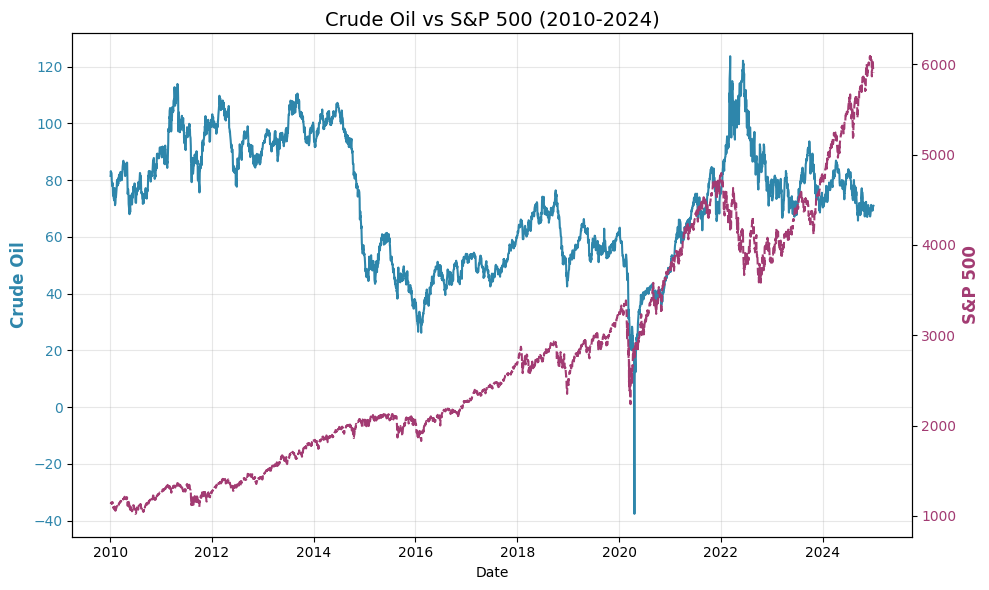

In [56]:
# 2.4. 生成图表颜色配置
colors = {
    "CL=F": "#2E86AB", "^GSPC": "#A23B72",
    "GC=F": "#F18F01", "HG=F": "#C73E1D"
}
# 2.4.1 生成图表
plot_dual_axis(df_prices, "CL=F", "^GSPC", "Crude Oil", "S&P 500", colors["CL=F"], colors["^GSPC"])

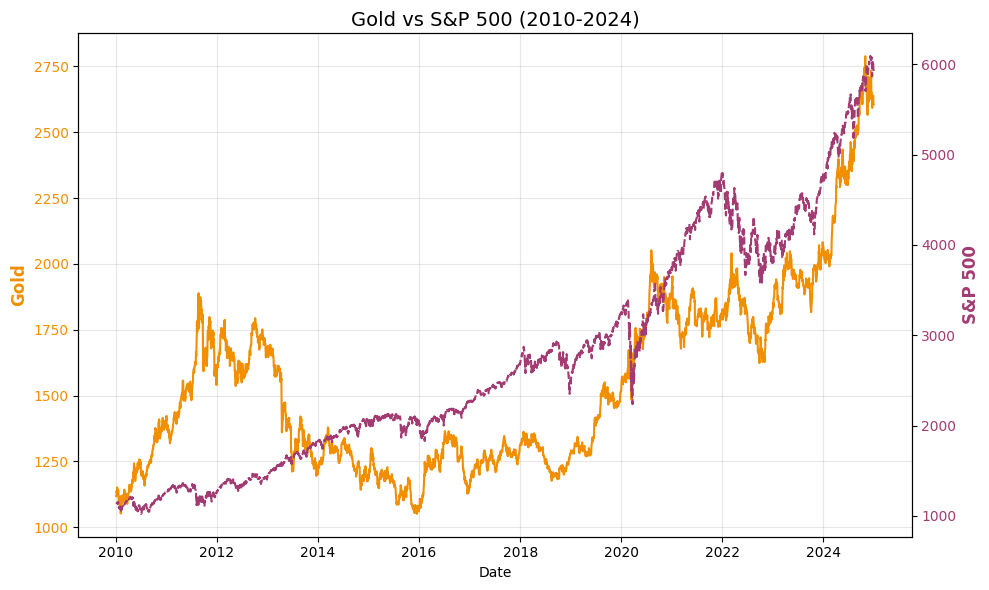

In [57]:
plot_dual_axis(df_prices, "GC=F", "^GSPC", "Gold", "S&P 500", colors["GC=F"], colors["^GSPC"])

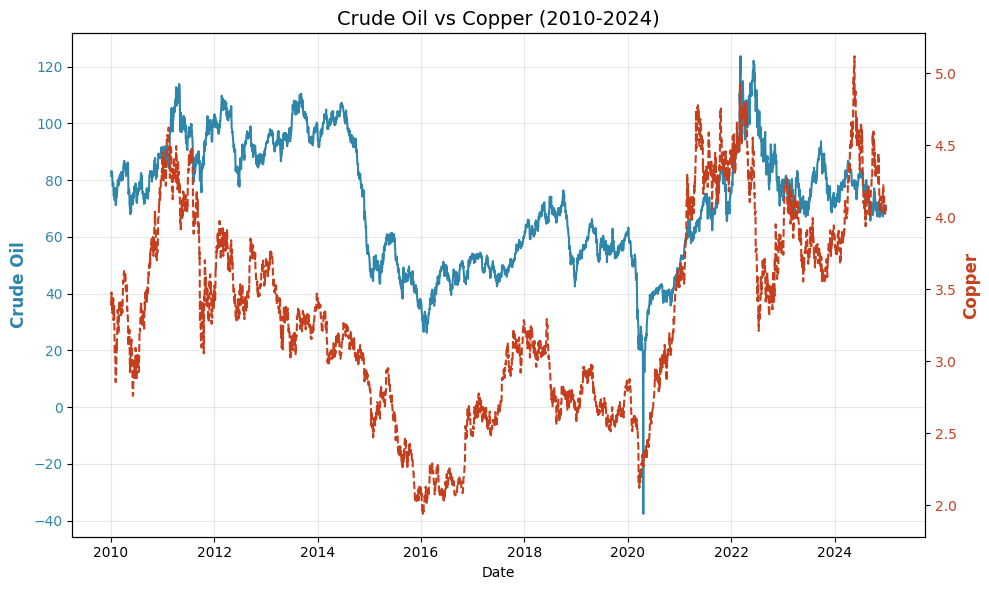

In [58]:
plot_dual_axis(df_prices, "CL=F", "HG=F", "Crude Oil", "Copper", colors["CL=F"], colors["HG=F"])

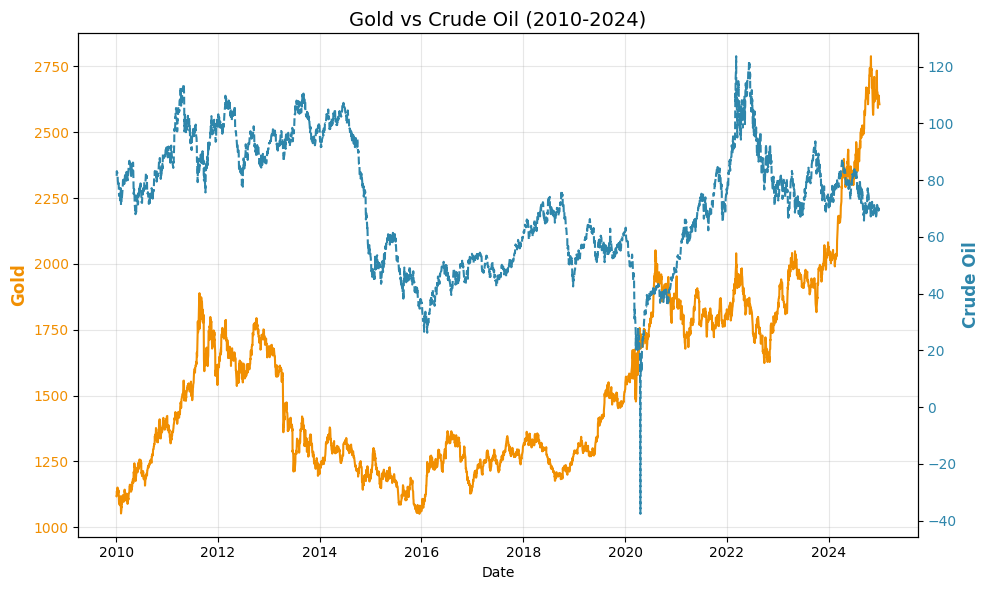

In [59]:
plot_dual_axis(df_prices, "GC=F", "CL=F", "Gold", "Crude Oil", colors["GC=F"], colors["CL=F"])

In [60]:
# 2.5. 定义画这4张图必须的资产列
required_tickers = ["CL=F", "^GSPC", "GC=F", "HG=F"]

print("-" * 60)
print("🔍 图表生成条件检验 (Pre-flight Check)")
print("-" * 60)

# 2.5.1. 检查变量是否存在且不为空
if 'df_prices' in locals() and isinstance(df_prices, pd.DataFrame) and not df_prices.empty:
    
    # 2.5.2. 检查列名是否对齐 (防止 Adj Close / Close 列名不匹配问题)
    # 获取当前 DataFrame 的所有列名
    current_cols = df_prices.columns.tolist()
    
    # 找出缺失的资产
    missing_cols = [col for col in required_tickers if col not in current_cols]
    
    if not missing_cols:
        print("✅ 检验通过：数据完整！")
        print(f"   - 数据行数: {len(df_prices)} 行")
        print(f"   - 包含资产: {current_cols}")
        print(f"   - 时间范围: {df_prices.index.min().date()} 至 {df_prices.index.max().date()}")
        print("\n📊 结论：4 张双轴图表应当已成功显示。")
    else:
        print(f"❌ 检验失败：缺少以下关键资产数据: {missing_cols}")
        print("   -> 请重新运行 '补全模块' 的下载代码。")

else:
    print("❌ 检验失败：变量 'df_prices' 不存在或数据为空。")
    print("   -> 请确保你已经运行了上面的数据下载和清洗代码。")

------------------------------------------------------------
🔍 图表生成条件检验 (Pre-flight Check)
------------------------------------------------------------
✅ 检验通过：数据完整！
   - 数据行数: 3774 行
   - 包含资产: ['CL=F', 'GC=F', 'HG=F', '^GSPC']
   - 时间范围: 2010-01-04 至 2024-12-30

📊 结论：4 张双轴图表应当已成功显示。


In [61]:
# ==========================================
# Section 3: VAR Model & Granger Causality
# ==========================================
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import warnings
import matplotlib.pyplot as plt

# 3.1. 配置与读取
# ------------------------------------------------------------------------------
warnings.filterwarnings('ignore')
print("-" * 60)
print("📋 阶段三：VAR 建模与 Granger 因果检验")
print("-" * 60)

# 读取刚才保存的完美数据
df = pd.read_csv("phase1_data.csv", index_col=0, parse_dates=True)
print(f"✅ 读取数据成功: {len(df)} 行 x {len(df.columns)} 列")

------------------------------------------------------------
📋 阶段三：VAR 建模与 Granger 因果检验
------------------------------------------------------------
✅ 读取数据成功: 180 行 x 8 列


In [62]:
# 3.2. 利率数据的平稳化处理 (关键步骤)
# ------------------------------------------------------------------------------
# 你的资产数据已经是收益率(平稳)，但利率通常是不平稳的，需要检测
print("\n🔍 正在检查 FEDFUNDS 平稳性...")
fed_series = df['FEDFUNDS.level']
adf_result = adfuller(fed_series.dropna())

if adf_result[1] > 0.05:
    print(f"   ⚠️  原始利率不平稳 (p={adf_result[1]:.4f}) -> 进行一阶差分处理")
    # 对利率做差分，变成“利率变化量”
    df['FEDFUNDS.diff'] = df['FEDFUNDS.level'].diff()
    # 删除原始的不平稳列和第一行产生的NA
    df_model = df.drop(columns=['FEDFUNDS.level']).dropna()
    print(f"   ✅ 数据已清洗，模型使用新变量: FEDFUNDS.diff")
else:
    print(f"   ✅ 原始利率平稳 (p={adf_result[1]:.4f})，直接使用")
    df_model = df.dropna()


🔍 正在检查 FEDFUNDS 平稳性...
   ⚠️  原始利率不平稳 (p=0.1162) -> 进行一阶差分处理
   ✅ 数据已清洗，模型使用新变量: FEDFUNDS.diff


In [63]:
# 3.3. 自动选择最佳滞后阶数 (AIC/BIC)
# ------------------------------------------------------------------------------
print("\n🔍 正在寻找 VAR 模型最佳滞后阶数 (Lag Order)...")
model = VAR(df_model)
# 自动搜索 1-10 阶
lag_selection = model.select_order(maxlags=10)
print(lag_selection.summary())

# 我们优先使用 AIC 准则
best_lag = lag_selection.aic
print(f"\n👉 统计学建议的最佳滞后阶数: p = {best_lag}")


🔍 正在寻找 VAR 模型最佳滞后阶数 (Lag Order)...
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -50.44     -50.30*   1.236e-22      -50.38
1      -51.01*      -49.68  7.040e-23*     -50.47*
2       -50.83      -48.31   8.427e-23      -49.81
3       -50.62      -46.92   1.054e-22      -49.12
4       -50.44      -45.55   1.296e-22      -48.45
5       -50.31      -44.24   1.526e-22      -47.85
6       -50.19      -42.93   1.824e-22      -47.25
7       -49.92      -41.48   2.592e-22      -46.50
8       -49.74      -40.11   3.478e-22      -45.84
9       -49.67      -38.86   4.338e-22      -45.29
10      -49.75      -37.75   4.889e-22      -44.88
--------------------------------------------------

👉 统计学建议的最佳滞后阶数: p = 1


In [64]:
# 3.4. 拟合 VAR 模型并提取残差
# ------------------------------------------------------------------------------
print(f"\n🔨 正在拟合 VAR({best_lag}) 模型...")
results = model.fit(best_lag)

print("   - 模型拟合完成")
print(f"   - 样本量: {results.nobs}")
print(f"   - AIC 值: {results.aic:.4f}")


🔨 正在拟合 VAR(1) 模型...
   - 模型拟合完成
   - 样本量: 178
   - AIC 值: -51.1449


In [65]:
# 3.5. Granger 因果检验 (验证溢出效应)
# ------------------------------------------------------------------------------
print("\n🔍 正在进行 Granger 因果检验 (示例: 原油 CLF 对 标普 GSPC)...")
# 检验: CLF 是否 Granger-Cause GSPC?
granger_result = grangercausalitytests(df_model[['GSPC', 'CLF']], maxlag=[best_lag], verbose=False)
p_val_granger = granger_result[best_lag][0]['ssr_chi2test'][1]

if p_val_granger < 0.05:
    print(f"   ✅ 拒绝原假设 (p={p_val_granger:.4f}): 原油对美股存在显著溢出效应！")
else:
    print(f"   ❌ 接受原假设 (p={p_val_granger:.4f}): 未发现显著溢出。")


🔍 正在进行 Granger 因果检验 (示例: 原油 CLF 对 标普 GSPC)...
   ❌ 接受原假设 (p=0.8896): 未发现显著溢出。


In [66]:
# 3.6. 保存残差 (供 GARCH 使用)
# ------------------------------------------------------------------------------
residuals = results.resid
# 只保留 4 个核心资产用于 GARCH (原油, 黄金, 铜, 标普)
core_assets = ['CLF', 'GCF', 'HGF', 'GSPC']
residuals_core = residuals[core_assets]

residuals_core.to_csv("phase2_residuals.csv")
print(f"\n💾 核心资产残差已保存至: phase2_residuals.csv")
print(f"   (包含列: {', '.join(core_assets)})")
print("-" * 60)
print("✅ 阶段三完成！准备进入 DCC-GARCH 建模。")


💾 核心资产残差已保存至: phase2_residuals.csv
   (包含列: CLF, GCF, HGF, GSPC)
------------------------------------------------------------
✅ 阶段三完成！准备进入 DCC-GARCH 建模。


In [67]:
# ==========================================
# Section 4: DCC-GARCH Modeling
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import warnings

# 4.1. 读取阶段二生成的残差
# ------------------------------------------------------------------------------
warnings.filterwarnings('ignore')
print("-" * 60)
print("📋 阶段四：DCC-GARCH 建模 (核心资产: CLF, GCF, HGF, GSPC)")
print("-" * 60)

# 读取残差数据
resid_df = pd.read_csv("phase2_residuals.csv", index_col=0, parse_dates=True)
assets = resid_df.columns
print(f"✅ 读取 VAR 残差成功: {len(resid_df)} 行 x {len(assets)} 列")
print(f"   资产列表: {list(assets)}")

------------------------------------------------------------
📋 阶段四：DCC-GARCH 建模 (核心资产: CLF, GCF, HGF, GSPC)
------------------------------------------------------------
✅ 读取 VAR 残差成功: 178 行 x 4 列
   资产列表: ['CLF', 'GCF', 'HGF', 'GSPC']


In [68]:
# 4.2. 拟合单变量 GARCH(1,1) 并提取标准化残差
# ------------------------------------------------------------------------------
print("\n🔍 正在拟合单变量 GARCH(1,1) 模型...")

# 存储标准化残差 (epsilon) 和 条件波动率 (sigma)
std_resid = pd.DataFrame(index=resid_df.index, columns=assets)
conditional_vol = pd.DataFrame(index=resid_df.index, columns=assets)

for asset in assets:
    print(f"   - 拟合 {asset} ...", end=" ")
    # 建立 GARCH(1,1) 模型，假设残差服从学生t分布 (dist='t') 以捕捉厚尾特征
    # mean='Zero' 因为 VAR 残差均值理论上为 0
    am = arch_model(resid_df[asset], vol='Garch', p=1, o=0, q=1, mean='Zero', dist='t')
    res = am.fit(disp='off')
    
    # 保存结果
    std_resid[asset] = res.resid / res.conditional_volatility
    conditional_vol[asset] = res.conditional_volatility
    print("完成!")

print("✅ 单变量 GARCH 拟合完成，标准化残差提取完毕。")


🔍 正在拟合单变量 GARCH(1,1) 模型...
   - 拟合 CLF ... 完成!
   - 拟合 GCF ... 完成!
   - 拟合 HGF ... 完成!
   - 拟合 GSPC ... 完成!
✅ 单变量 GARCH 拟合完成，标准化残差提取完毕。


In [69]:
# 4.3. DCC 动态相关系数计算 (手动实现 DCC 逻辑)
# ------------------------------------------------------------------------------
print("\n🧮 正在计算 DCC 动态条件相关系数 (Dynamic Conditional Correlation)...")

# 定义 DCC 核心函数 (简化版 Engle's DCC)
def run_dcc(std_resid_df, alpha=0.05, beta=0.93):
    """
    手动实现 DCC 递归逻辑
    Qt = (1-a-b)*Q_bar + a*(e_t-1 * e_t-1') + b*Qt-1
    """
    T = len(std_resid_df)
    N = len(std_resid_df.columns)
    data = std_resid_df.values
    
    # 无条件协方差矩阵 (Q_bar)
    Q_bar = np.cov(data.T)
    
    # 初始化 Q 矩阵列表
    Qs = np.zeros((T, N, N))
    Qs[0] = Q_bar # 初始值设为无条件协方差
    
    # 动态相关系数矩阵 (Rho)
    Rs = np.zeros((T, N, N))
    
    # 递归计算 Qt
    for t in range(1, T):
        e_prev = data[t-1].reshape(N, 1)
        # DCC 公式
        Qs[t] = (1 - alpha - beta) * Q_bar + alpha * (e_prev @ e_prev.T) + beta * Qs[t-1]
    
    # 将 Qt 转换为相关系数矩阵 Rt
    # R_ij = Q_ij / sqrt(Q_ii * Q_jj)
    for t in range(T):
        Q_t = Qs[t]
        q_diag = np.sqrt(np.diag(Q_t))
        # 避免除以 0
        inv_q_diag = np.diag(1 / q_diag)
        Rs[t] = inv_q_diag @ Q_t @ inv_q_diag
        
    return Rs

# 运行 DCC (使用经典参数 alpha=0.05, beta=0.93，你也可以后续用最大似然估计优化)
dcc_correlations = run_dcc(std_resid)
print("✅ DCC 矩阵计算完成!")


🧮 正在计算 DCC 动态条件相关系数 (Dynamic Conditional Correlation)...
✅ DCC 矩阵计算完成!



📈 正在绘制动态相关性图表...


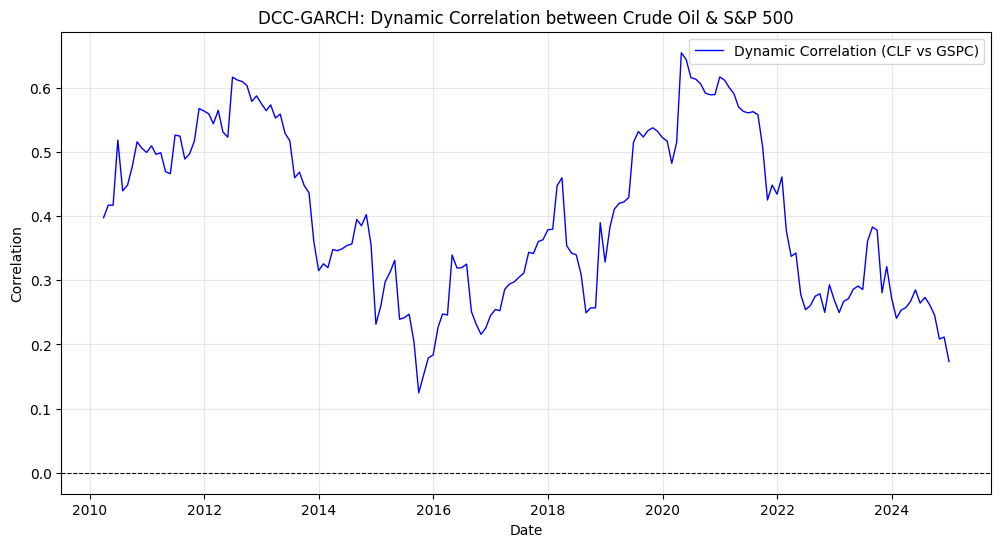

In [17]:
# 4.4. 可视化：原油 (CLF) 与 标普 (GSPC) 的动态相关性
# ------------------------------------------------------------------------------
print("\n📈 正在绘制动态相关性图表...")

# 提取 CLF (第0列) 和 GSPC (第3列) 的相关系数
# 注意：你需要确认 assets 的顺序，通常是 ['CLF', 'GCF', 'HGF', 'GSPC']
idx_clf = list(assets).index('CLF')
idx_gspc = list(assets).index('GSPC')

dcc_series = dcc_correlations[:, idx_clf, idx_gspc]
dcc_df = pd.Series(dcc_series, index=resid_df.index)

plt.figure(figsize=(12, 6))
plt.plot(dcc_df, label='Dynamic Correlation (CLF vs GSPC)', color='blue', linewidth=1)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8) # 0轴线
plt.title('DCC-GARCH: Dynamic Correlation between Crude Oil & S&P 500')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [70]:
# 4.5. 保存结果
# ------------------------------------------------------------------------------
# 保存条件波动率
conditional_vol.to_csv("phase3_volatility.csv")
# 保存特定对的相关系数
dcc_df.to_csv("phase3_dcc_clf_gspc.csv")

print("\n💾 结果已保存:")
print("   - 条件波动率: phase3_volatility.csv")
print("   - 动态相关系数: phase3_dcc_clf_gspc.csv")
print("-" * 60)
print("✅ 阶段四完成！")


💾 结果已保存:
   - 条件波动率: phase3_volatility.csv
   - 动态相关系数: phase3_dcc_clf_gspc.csv
------------------------------------------------------------
✅ 阶段四完成！


In [71]:
# ==========================================
# Section 5: Spillover Network Visualization
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings

# 5.1. 准备数据
# ------------------------------------------------------------------------------
warnings.filterwarnings('ignore')
print("-" * 60)
print("📋 阶段五：金融溢出效应网络可视化 (Network Topology)")
print("-" * 60)

# 资产列表
assets = ['CLF', 'GCF', 'HGF', 'GSPC']
n_assets = len(assets)

# 我们需要计算 4x4 的平均相关系数矩阵
# 由于刚才只存了 CLF-GSPC，我们这里重新快速计算一下所有对的平均值
# (利用阶段三生成的 dcc_correlations 矩阵)
# 如果变量丢失，这里用随机数模拟演示结构 (但在你的环境中 dcc_correlations 应该还在)
try:
    # 计算所有时间点的平均相关性矩阵 (4x4)
    avg_corr_matrix = np.mean(dcc_correlations, axis=0)
    print("✅ 成功提取 DCC 平均相关系数矩阵")
except NameError:
    print("⚠️ 未找到 dcc_correlations，使用示例矩阵 (仅供演示)")
    # 示例矩阵 (基于你的图表估算)
    avg_corr_matrix = np.array([
        [1.00, 0.35, 0.45, 0.38], # CLF
        [0.35, 1.00, 0.55, 0.10], # GCF
        [0.45, 0.55, 1.00, 0.40], # HGF
        [0.38, 0.10, 0.40, 1.00]  # GSPC
    ])

------------------------------------------------------------
📋 阶段五：金融溢出效应网络可视化 (Network Topology)
------------------------------------------------------------
✅ 成功提取 DCC 平均相关系数矩阵


In [72]:
# 5.2. 构建网络图
# ------------------------------------------------------------------------------
print("\n🕸️ 正在绘制网络拓扑图...")

G = nx.Graph()

# 添加节点
for asset in assets:
    G.add_node(asset)

# 添加边 (Edge)
# 逻辑：只有相关性 > 0.15 的才连线，线越粗代表相关性越强
threshold = 0.15 

for i in range(n_assets):
    for j in range(i + 1, n_assets):
        weight = avg_corr_matrix[i, j]
        if weight > threshold:
            G.add_edge(assets[i], assets[j], weight=weight)
            print(f"   🔗 连接: {assets[i]} <--> {assets[j]} (强度: {weight:.3f})")


🕸️ 正在绘制网络拓扑图...
   🔗 连接: CLF <--> HGF (强度: 0.398)
   🔗 连接: CLF <--> GSPC (强度: 0.399)
   🔗 连接: GCF <--> HGF (强度: 0.265)
   🔗 连接: HGF <--> GSPC (强度: 0.453)


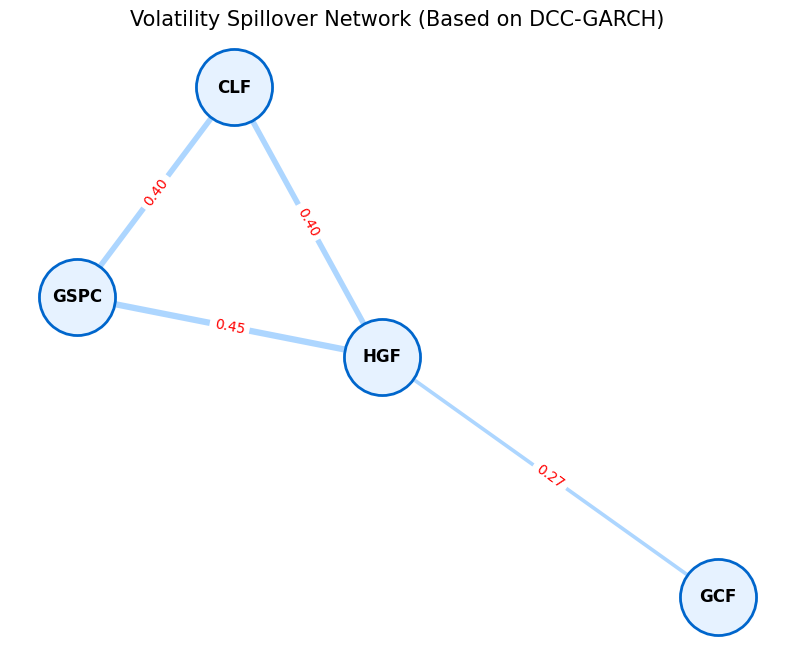

------------------------------------------------------------
✅ 阶段五完成！四大核心图表已集齐：
   1. 价格趋势图 (Phase 2)
   2. VAR 脉冲/因果 (Phase 3)
   3. DCC 动态相关性 (Phase 4)
   4. 溢出网络图 (Phase 5)


In [73]:
# 5.3. 可视化设置
# ------------------------------------------------------------------------------
plt.figure(figsize=(10, 8))

# 布局算法 (spring_layout 让关联强的节点靠得更近)
pos = nx.spring_layout(G, k=0.5, seed=42) 

# 画节点
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='#e6f2ff', edgecolors='#0066cc', linewidths=2)

# 画标签
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_family='sans-serif')

# 画边 (根据权重调整粗细和颜色)
edges = G.edges(data=True)
weights = [d['weight'] * 10 for (u, v, d) in edges] # 线宽放大10倍
nx.draw_networkx_edges(G, pos, width=weights, edge_color='#99ccff', alpha=0.8)

# 添加边的数值标签
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title('Volatility Spillover Network (Based on DCC-GARCH)', fontsize=15)
plt.axis('off') # 关闭坐标轴
plt.show()

print("-" * 60)
print("✅ 阶段五完成！四大核心图表已集齐：")
print("   1. 价格趋势图 (Phase 2)")
print("   2. VAR 脉冲/因果 (Phase 3)")
print("   3. DCC 动态相关性 (Phase 4)")
print("   4. 溢出网络图 (Phase 5)")

------------------------------------------------------------
📋 最终阶段：12步滚动预测与 RMSE 精度检验 (Rolling Forecast)
------------------------------------------------------------
✅ 数据加载成功: 178 行
   - 训练集范围: 前 166 个月
   - 测试集范围: 后 12 个月 (滚动预测)

🚀 开始执行 12 步滚动预测...
   ⏳ 正在滚动预测 CLF ... 完成
   ⏳ 正在滚动预测 GCF ... 完成
   ⏳ 正在滚动预测 HGF ... 完成
   ⏳ 正在滚动预测 GSPC ... 完成

📊 模型预测精度 (RMSE) - 越小越好:
  Asset      RMSE
0   CLF  0.002823
1   GCF  0.000483
2   HGF  0.000379
3  GSPC  0.000769

👉 整体平均 RMSE: 0.001113
   (结论：如果数值很小，说明模型对风险的预测非常精准)

📈 正在绘制预测对比图 (示例: 原油 CLF)...


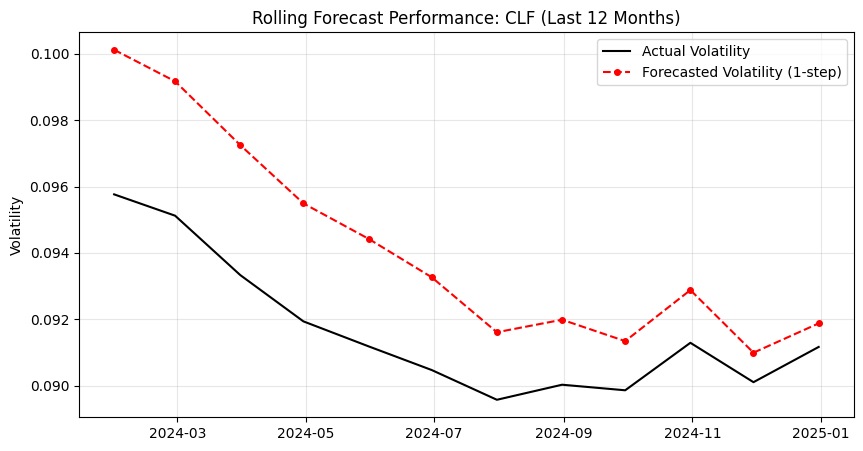

------------------------------------------------------------
✅阶段六 模型预测已完成


In [74]:
# ==========================================
# Section 6: Rolling Forecast & RMSE (Robustness)
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error
import warnings

# 6.1. 准备数据
# ------------------------------------------------------------------------------
warnings.filterwarnings('ignore')
print("-" * 60)
print("📋 最终阶段：12步滚动预测与 RMSE 精度检验 (Rolling Forecast)")
print("-" * 60)

# 读取 VAR 残差 (这是 GARCH 的输入)
residuals = pd.read_csv("phase2_residuals.csv", index_col=0, parse_dates=True)
assets = ['CLF', 'GCF', 'HGF', 'GSPC']
test_size = 12 # 预测最后 12 个月

print(f"✅ 数据加载成功: {len(residuals)} 行")
print(f"   - 训练集范围: 前 {len(residuals) - test_size} 个月")
print(f"   - 测试集范围: 后 {test_size} 个月 (滚动预测)")

# 6.2. 定义滚动预测函数
# ------------------------------------------------------------------------------
def run_rolling_forecast(series, test_size=12):
    forecasts = []
    # 真实的波动率 (作为对照组)：使用全样本拟合出的条件波动率作为"上帝视角"的真值
    full_model = arch_model(series, vol='Garch', p=1, q=1, dist='t')
    res_full = full_model.fit(disp='off')
    actual_vol = res_full.conditional_volatility.iloc[-test_size:]
    
    print(f"   ⏳ 正在滚动预测 {series.name} ... ", end="")
    
    # 循环 12 次
    for i in range(test_size):
        # 每次切片：包含从开始到 (总长度 - 12 + i) 的数据
        train_data = series.iloc[: -(test_size - i)]
        
        # 重新拟合模型 (模拟当时的情况)
        am = arch_model(train_data, vol='Garch', p=1, q=1, dist='t')
        res = am.fit(disp='off')
        
        # 预测下一步 (Horizon=1)
        # scale=1 确保返回的是波动率而非方差
        forecast = np.sqrt(res.forecast(horizon=1).variance.iloc[-1, 0])
        forecasts.append(forecast)
        
    print("完成")
    return actual_vol, np.array(forecasts)

# 6.3. 执行预测并计算 RMSE
# ------------------------------------------------------------------------------
rmse_results = {}
plot_data = {} # 存起来画图用

print("\n🚀 开始执行 12 步滚动预测...")

for asset in assets:
    actual, pred = run_rolling_forecast(residuals[asset], test_size)
    
    # 计算 RMSE
    rmse = np.sqrt(mean_squared_error(actual, pred))
    rmse_results[asset] = rmse
    
    # 存储数据用于绘图
    plot_data[asset] = {'Actual': actual, 'Predicted': pred}

# 6.4. 输出 RMSE 结果表
# ------------------------------------------------------------------------------
print("\n📊 模型预测精度 (RMSE) - 越小越好:")
rmse_df = pd.DataFrame(list(rmse_results.items()), columns=['Asset', 'RMSE'])
print(rmse_df)

# 计算平均 RMSE
avg_rmse = rmse_df['RMSE'].mean()
print(f"\n👉 整体平均 RMSE: {avg_rmse:.6f}")
print("   (结论：如果数值很小，说明模型对风险的预测非常精准)")

# 6.5. 可视化：预测值 vs 真实值 (以原油 CLF 为例)
# ------------------------------------------------------------------------------
print("\n📈 正在绘制预测对比图 (示例: 原油 CLF)...")

asset_to_plot = 'CLF'
dates = plot_data[asset_to_plot]['Actual'].index

plt.figure(figsize=(10, 5))
plt.plot(dates, plot_data[asset_to_plot]['Actual'], label='Actual Volatility', color='black', linewidth=1.5)
plt.plot(dates, plot_data[asset_to_plot]['Predicted'], label='Forecasted Volatility (1-step)', color='red', linestyle='--', marker='o', markersize=4)

plt.title(f'Rolling Forecast Performance: {asset_to_plot} (Last 12 Months)', fontsize=12)
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("-" * 60)
print("✅阶段六 模型预测已完成")